# Detect faulty data by non-changing signal elements
Here, we investigate whether faulty data can be detected by simply looking at data points which show zero change.  Indeed we find that the distribution of the values with zero change match the boundaries of the recording scale.

In [177]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyxona import File
import quantities as pq
import ripple_detection as rd
import tools
from matplotlib.ticker import FormatStrFormatter
from scipy.signal import convolve as conv
from scipy import stats
import seaborn as sns

from tqdm import tqdm
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [178]:
path = "/home/jovyan/work/RippleSpindleCoupling/data/"

# load file info from names
df_info = tools.generate_fileinfo(path)

# load info from experimental nodes
fname_notes = 'NotesData.ods'
df_notes = tools.load_notes(path, fname_notes)

# merge both
df_info = pd.merge(df_notes, df_info, on=['id', 'date', 'session'])

In [179]:
df_info = df_info.drop(['rec_start', 'rec_stop', 'notes'], axis=1)


#### For each file find values with zero change to previous value. Create a histogram of which values these are.

In [180]:
for key in ['hpc', 'ctx']:
    df_info['hist_lfp_' + key] = None

bins = np.arange(-1200, 1200, 1)

for index, row in df_info.iterrows():
    fname = row['fname']
    f = File(fname)
    lfp = {
        'hpc': f.analog_signals[0].signal.magnitude, # hippocampal signal 
        'ctx': f.analog_signals[1].signal.magnitude, # cortex signal
    }
    
    for key, lfp_i in lfp.items():
        diff = np.diff(lfp_i)
        diff_bool = diff == 0.
        vals_diff0 = lfp_i[1:][diff_bool]
        hst, _ = np.histogram(vals_diff0, bins=bins)
        row['hist_lfp_' + key] = hst
    

/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(f, dtype=sample_dtype, count=sample_count)


In [181]:
df_info['id_date_sess'] = df_info['id']+'_'+df_info['date']+'_'+df_info['session']

In [182]:
def plot(*args,**kwargs):
    plt.plot(bins[:-1], args[0].iloc[0], **kwargs)

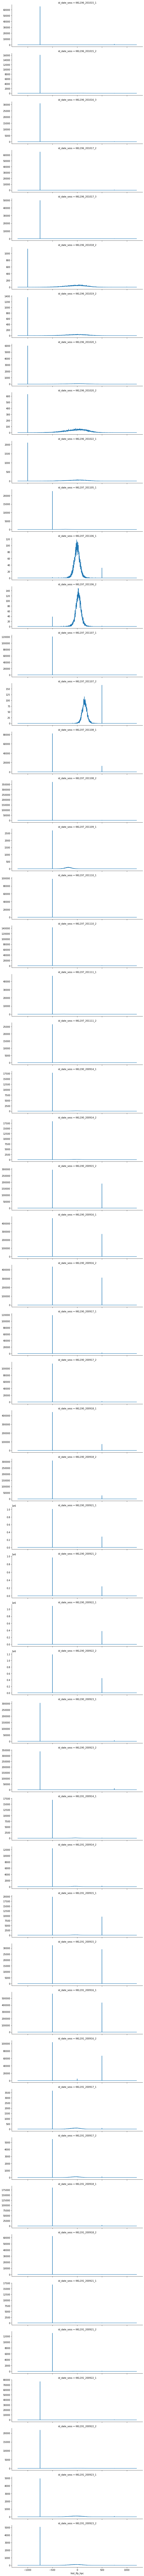

In [183]:
g = sns.FacetGrid(df_info, row='id_date_sess', sharey=False, aspect=3.)
g.map(plot, "hist_lfp_hpc")

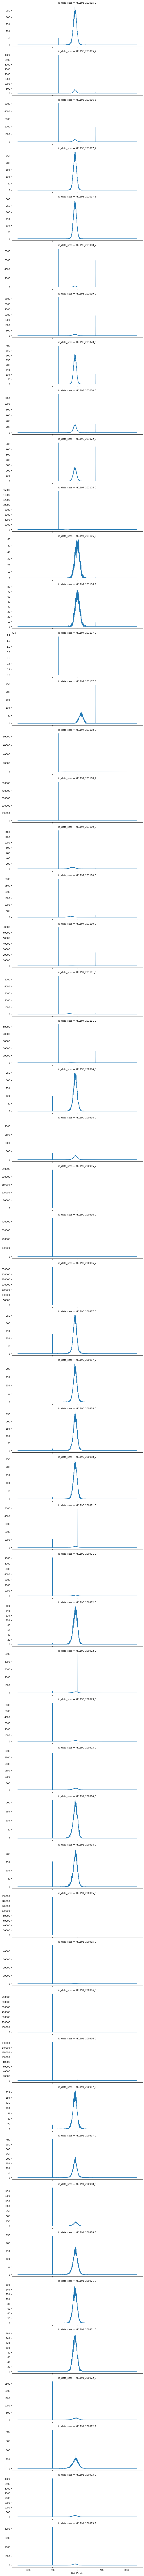

In [184]:
g = sns.FacetGrid(df_info, row='id_date_sess', sharey=False, aspect=3.)
g.map(plot, "hist_lfp_ctx")

### Observation:
Detected events with zero change do indeed reflect limit of recording device for both hpc and ctx recordings. However in some cases, such as KKL197-201106, it is also evident that these events do occur within the normal recording rage. This suggests that constant values alone may not necessarily imply faulty data. Therefore we need an additional criterium. 



## Quantification of event lenghts with zero signal change


In [188]:
for key in ['hpc', 'ctx']:
    df_info[key + '_' + 'zero_change_events_startend'] = None
    df_info[key + '_' + 'zero_change_events_values'] = None
    df_info[key + '_' + 'zero_change_events_length'] = None

for index, row in tqdm(df_info.iterrows()):
    fname = row['fname']
    f = File(fname)
    lfp = {
        'hpc': f.analog_signals[0].signal.magnitude, # hippocampal signal 
        'ctx': f.analog_signals[1].signal.magnitude, # cortex signal
    }
    
    for key, lfp_i in lfp.items():
        start_end, values = tools.get_events_with_zero_change(
            lfp_i, tol=10e-10, return_values=True, minimum_duration=0)
        row[key + '_' + 'zero_change_events_startend'] = start_end
        row[key + '_' + 'zero_change_events_values'] = values
        row[key + '_' + 'zero_change_events_length'] = start_end[:, 1] - start_end[:, 0]

0it [00:00, ?it/s]/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(f, dtype=sample_dtype, count=sample_count)
53it [06:13,  7.04s/it]


Text(0.5, 0.98, 'Length distribution of zero-change events')

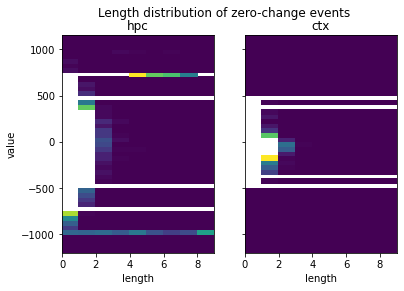

In [190]:
# plot results
fig, ax = plt.subplots(1,2, squeeze=False, sharey=True)
for i, key in enumerate(['hpc', 'ctx']):
    lengths=np.concatenate(df_info[key + '_' + 'zero_change_events_length'])
    values=np.concatenate(df_info[key + '_' + 'zero_change_events_values'])
    
    ax[0, i].hist2d(lengths, values,
           bins=[np.arange(0, 10, 1),
                 np.arange(-1200, 1200, 50),
                 ],
           cmax=100.,
           )
    ax[0, i].set_xlabel('length')
    ax[0, i].set_title(key)
    
ax[0, 0].set_ylabel('value')
fig.suptitle('Length distribution of zero-change events')

NameError: name 'pdb' is not defined

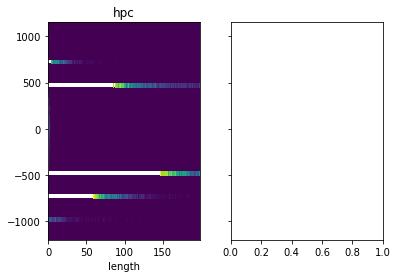

In [246]:
# plot results
fig, ax = plt.subplots(1,2, squeeze=False, sharey=True)
for i, key in enumerate(['hpc', 'ctx']):
    lengths=np.concatenate(df_info[key + '_' + 'zero_change_events_length'])
    values=np.concatenate(df_info[key + '_' + 'zero_change_events_values'])
    
    ax[0, i].hist2d(lengths, values,
           bins=[np.arange(0, 200, 1),
                 np.arange(-1200, 1200, 50),
                 ],
           cmax=100.,
           )
    ax[0, i].set_xlabel('length')
    ax[0, i].set_title(key)
    
    if np.any(np.abs(values) > 500):
        pdb.set_trace()
    
ax[0, 0].set_ylabel('value')
fig.suptitle('Length distribution of zero-change events')

#### Observation
Longer zero change events are almost always associated with fixed boundaries, likely reflecting the extremes of the recording range.
This data includes all available animals and sessions.

#### Conclusion
We can therefore use zero change between more than three consecutive values as a safe way to remove noise.

### Number of events per session with more than 3 consecutive constant values

In [191]:
for key in ['hpc', 'ctx']:
    df_info[key + '_' + 'n_events_zero_change_ge3'] = None
    
for i, row in df_info.iterrows():
    for key in ['hpc', 'ctx']:
        length = row[key + '_' + 'zero_change_events_length']
        row[key + '_' + 'n_events_zero_change_ge3'] = np.sum(length>=3)

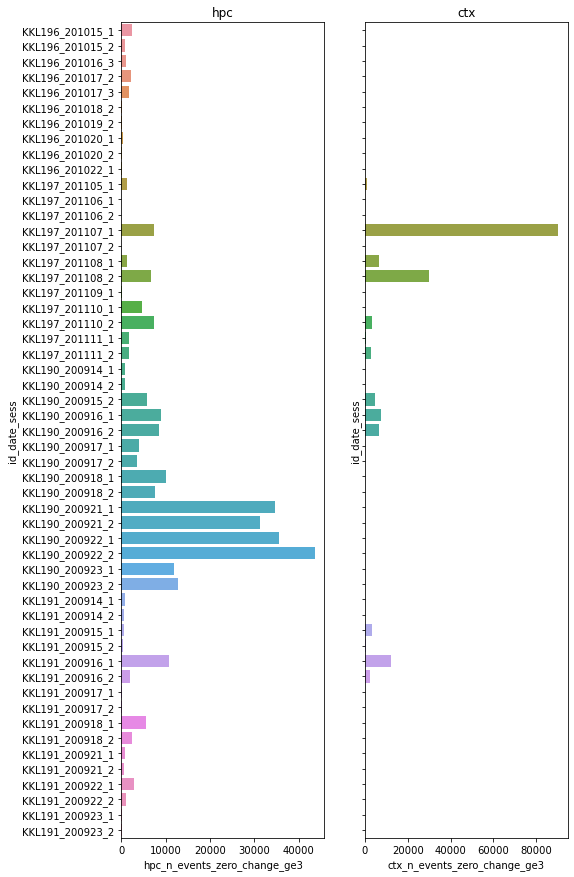

In [204]:
fig, ax = plt.subplots(1, 2, figsize=(8,15), sharey=True)
for i, key in enumerate(['hpc', 'ctx']):
    sns.barplot(x=key + '_' + 'n_events_zero_change_ge3', y='id_date_sess', data=df_info, ax=ax[i])
    ax[i].set_title(key)

### Visualize events with zero change between consecutive values

#### Animal: KKL197, 201107, session 1
Comment: weird signal towards end, live signal dropped 500 µV

In [213]:
df_i = df_info.loc[13]

In [214]:
startend = df_i['hpc_zero_change_events_startend']
lengths = df_i['hpc_zero_change_events_length']

In [215]:
fname = df_i['fname']

f = File(fname)
lfp = {
    'hpc': f.analog_signals[0].signal.magnitude, # hippocampal signal 
    'hpc_samplingrate': f.analog_signals[0].sample_rate.magnitude
}
sampling_interval = 1./lfp['hpc_samplingrate']
t_stop = len(lfp['hpc'])*sampling_interval
t = np.arange(0, t_stop, sampling_interval)



/opt/conda/lib/python3.8/site-packages/pyxona/core.py:589: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  data = np.fromfile(f, dtype=sample_dtype, count=sample_count)


In [230]:
startend_sel = startend[lengths>50,:][::100]
lengths_sel = lengths[lengths>50][::100]

In [231]:
lengths_sel

array([104,  60,  51, 149,  56])

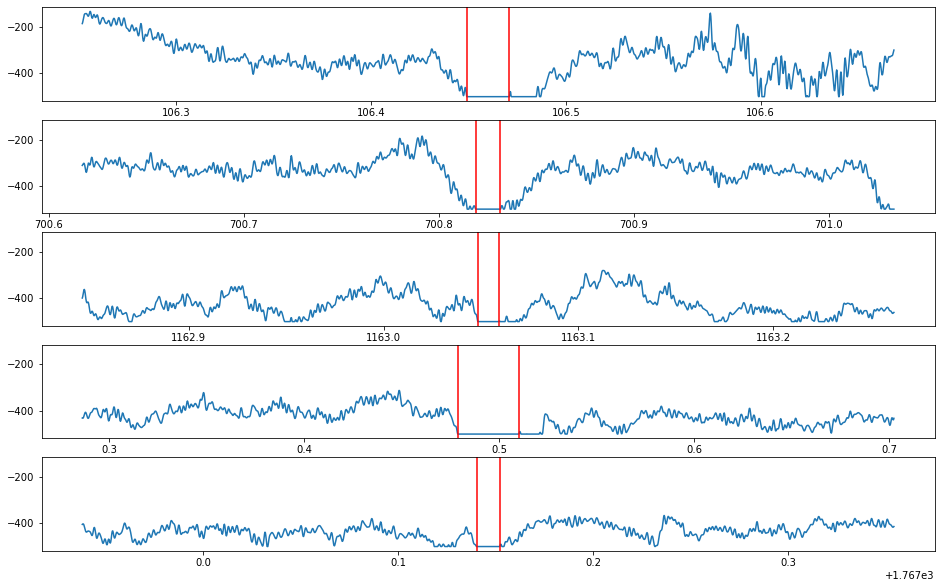

In [236]:
fig, ax = plt.subplots(
    len(startend_sel), 1, squeeze=False, sharey=True, figsize=(16,10))


for i, startend_i in enumerate(startend_sel):
    pos_center = int(np.mean(startend_i))
    wdnw = 1000
    ax[i, 0].plot(
        t[pos_center-wdnw:pos_center+wdnw],
        lfp['hpc'][pos_center-wdnw:pos_center+wdnw])
    ax[i, 0].axvline(t[startend_i[0]], c='r')
    ax[i, 0].axvline(t[startend_i[1]], c='r')

### Get min/max values for each session

In [252]:
for key in ['hpc', 'ctx']:
    df_info[key + '_rec_min'] = None
    df_info[key + '_rec_max'] = None

for index, row in df_info.iterrows():
    fname = row['fname']
    f = File(fname)
    lfp = {
        'hpc': f.analog_signals[0].signal.magnitude, # hippocampal signal 
        'ctx': f.analog_signals[1].signal.magnitude, # cortex signal
    }
    
    for key, lfp_i in lfp.items():
        row[key + '_rec_min'] = np.min(lfp_i)
        row[key + '_rec_max'] = np.max(lfp_i)



In [253]:
print(df_info[['id', 'date', 'session', 'hpc_rec_min', 'hpc_rec_max', 'ctx_rec_min', 'ctx_rec_max']])

        id    date session hpc_rec_min hpc_rec_max ctx_rec_min ctx_rec_max
0   KKL196  201015       1        -750     749.954        -375     277.885
1   KKL196  201015       2        -750     749.954        -375     374.977
2   KKL196  201016       3        -750     749.954        -375     374.977
3   KKL196  201017       2        -750     749.954    -308.304      249.39
4   KKL196  201017       3        -750     749.954     -353.05     170.769
5   KKL196  201018       2       -1000     999.939        -375     374.977
6   KKL196  201019       2       -1000     845.764        -375     374.977
7   KKL196  201020       1       -1000     999.939        -375     374.977
8   KKL196  201020       2       -1000     811.951        -375     374.977
9   KKL196  201022       1       -1000     999.939        -375     374.977
10  KKL197  201105       1        -500     356.079        -375     117.531
11  KKL197  201106       1        -500     499.969        -375     374.977
12  KKL197  201106       